In [1]:
# Install required packages
# Run this cell first if you haven't already installed these packages

import sys
import subprocess

def install_package(package):
    """Install a package using pip"""
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# List of required packages
required_packages = [
    'gymnasium',           # Reinforcement learning environments (CartPole)
    'numpy',              # Numerical computing
    'matplotlib',         # Plotting and visualization
    'pygame',             # For rendering environments
]

print("Checking and installing required packages...")
print("=" * 60)

for package in required_packages:
    try:
        __import__(package.split('[')[0])  # Handle packages with extras like 'package[extra]'
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        install_package(package)
        print(f"✓ {package} installed successfully")

print("=" * 60)
print("All required packages are installed!")
print("\nYou can now run the rest of the notebook.")

Checking and installing required packages...
✓ gymnasium already installed
✓ numpy already installed
✓ matplotlib already installed
✓ pygame already installed
All required packages are installed!

You can now run the rest of the notebook.
✓ pygame already installed
All required packages are installed!

You can now run the rest of the notebook.


C:\Users\chris.reckner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
# Configure matplotlib for Google Colab (prevents flashing)
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()  # Turn on interactive mode

print("✓ Matplotlib configured for smooth updates in Google Colab")

✓ Matplotlib configured for smooth updates in Google Colab


# CartPole PID Control with Genetic Algorithm

## What You're Actually Doing Here

You've got a cart with a pole on it. The pole wants to fall over. Your job is to tune a PID controller so it doesn't. Simple, right? Wrong. Tuning PID controllers manually can take long times, with many instances of trial and error - you tweak one parameter, something improves, then two other things break. In FRC this process can feel even longer as you would need to push code in between each update (unless you have a custom live input PID) which can make "simple tuning" take all night if not days.

So instead of spending hours doing that, we're letting evolution do the work. That's what genetic algorithms are good for: searching through parameter spaces that would take you forever to explore by hand.

**What you should get out of this:**
- See how genetic algorithms actually work (not just read about them)
- Understand what Kp, Ki, and Kd actually do to a control system
- Watch evolution happen in real time

---

## The Problem

You've got a cart on a track. There's a pole attached to the cart with a hinge. The pole starts slightly tilted. Physics wants to make it fall. You need to push the cart left or right to keep the pole balanced.

This is called an inverted pendulum problem. Engineers love this one because it's simple enough to understand but hard enough to be interesting.

**How we're solving it:**
- Measure the pole angle (that's your error signal)
- Feed it to a PID controller (we'll explain this later)
- Controller outputs a force value
- Apply that force to the cart
- Repeat every 0.02 seconds

---

## Parameters You Can Mess With

### Environment Parameters
| Parameter | What it does | Default |
|-----------|-------------|---------|
| `FAILURE_ANGLE_DEGREES` | How far the pole can tilt before you lose | 90° |
| `FORCE_MAGNITUDE` | Max force you can push with | 10.0 N |
| `REWARD_TYPE` | What counts as "good" performance | "comprehensive" |

The default CartPole only lets the pole tilt 12 degrees. That's make it good for quick itterations, but less visually entertaining and understandable. We set it to 90 degrees by default. 

**Reward types** (this is important):
- `"default"`: Get 1 point per timestep you survive. That's it.
- `"angle_based"`: Get more points when the pole is closer to vertical
- `"comprehensive"`: Balance multiple things - angle, velocity, position
- `"negative_angle"`: Punishment-based (usually works worse, but try it)
- `"custom"`: Write your own (see challenge section)

### Genetic Algorithm Settings
| Parameter | What it does | Default | Notes |
|-----------|-------------|---------|-------|
| `POPULATION_SIZE` | How many PID controllers per generation | 20 | More = slower but explores better |
| `GENERATIONS` | How many rounds of evolution | 30 | Usually converges before this |
| `EPISODES_PER_EVAL` | Test runs to average | 3 | Reduces random luck |
| `MUTATION_RATE` | How often parameters randomly change | 0.3 | Lower = more stable |
| `MUTATION_EFFECT` | How BIG those changes are | 0.15 | Lower = fine tuning |
| `CROSSOVER_RATE` | How often parents mix genes | 0.8 | Usually keep this high |
| `ELITISM` | Always keep the best solution | True | Turn this off at your own risk |

### PID Search Ranges
These tell the algorithm where to look for good parameters:

| Parameter | Range | What it controls |
|-----------|-------|---------|
| `KP_RANGE` | (-50, 50) | Proportional: react to current error |
| `KI_RANGE` | (-20, 20) | Integral: fix accumulated drift |
| `KD_RANGE` | (-30, 30) | Derivative: dampen oscillations |

Notice the ranges include negative values. Yeah, that's intentional. Sometimes you need negative gains to make the controller stable. These ranges are also needlessly large to let the algorithm converge more visually, starting from worse parameter sets.

---

## How the Genetic Algorithm Works

Okay, here's the process. It's not complicated, just repetitive:

```
START:
  Make a random population of PID controllers (Kp,Ki,Kd)
  
LOOP (for each generation):
  1. Test every controller on the CartPole
  2. Give each one a fitness score (higher = better)
  3. Pick the good ones (tournament selection)
  4. Make them "reproduce" (crossover their parameters)
  5. Randomly mutate some parameters (exploration)
  6. Keep the best one no matter what (elitism)
  7. This is your new population
  
  If we've done enough generations, STOP
  If we're close enough to converging, STOP
  Otherwise, go back to step 1
  
RESULT: Best PID parameters found
```

That's it. Evolution is just trial and error with a clever selection strategy.

---

## What's a PID Controller Anyway?

If you've never seen this before: PID stands for Proportional-Integral-Derivative. It's a control algorithm that's been around since the 1920s. It's used in EVERYTHING - cruise control, temperature control, drones, industrial robots, you name it.

The math is simple:

**force = Kp × error + Ki × ∫(error)dt + Kd × d(error)/dt**

Breaking that down:
- **Kp (Proportional):** Push harder when the pole is tilted more. Simple.
- **Ki (Integral):** If there's a constant drift, this fixes it over time. Prevents steady-state error.
- **Kd (Derivative):** If the pole is falling fast, this adds damping. Prevents overshooting.

The problem? Picking good values for Kp, Ki, and Kd. That's where the genetic algorithm comes in.

---

## Things to Try

2. **Make it harder:** Keep it at 90 degrees and reduce `FORCE_MAGNITUDE = 5.0`
3. **Speed things up:** Crank `POPULATION_SIZE = 50` and `MUTATION_RATE = 0.5` (less stable but faster)
4. **Fine-tune existing solution:** Lower `MUTATION_EFFECT = 0.05` (smaller changes)
5. **Try different rewards:** Change `REWARD_TYPE` and see how it affects the final controller behavior

Don't just run it once and call it done. Change stuff. Break it. See what happens.



In [3]:
# ============================================================================
# IMPORT CONFIGURATION FROM EXTERNAL FILE
# ============================================================================
# All hyperparameters and constants are now in config.py for easier management

from config import *

# ============================================================================
# Display loaded configuration
# ============================================================================
print("="*70)
print("CONFIGURATION LOADED FROM config.py")
print("="*70)
print(f"Environment:")
print(f"  Failure angle: {FAILURE_ANGLE_DEGREES}°")
print(f"  Force magnitude: {FORCE_MAGNITUDE}")
print(f"  Reward type: {REWARD_TYPE}")
print(f"\nPID Controller:")
print(f"  Integral limit: {INTEGRAL_LIMIT}")
print(f"  Timestep: {PID_TIMESTEP}")
print(f"\nGenetic Algorithm:")
print(f"  Population: {POPULATION_SIZE} individuals")
print(f"  Elite count: {ELITE_COUNT}")
print(f"  Generations: {GENERATIONS}")
print(f"  Episodes per evaluation: {EPISODES_PER_EVAL}")
print(f"  Search ranges: Kp{KP_RANGE}, Ki{KI_RANGE}, Kd{KD_RANGE}")
print(f"  Mutation rate: {MUTATION_RATE}, effect: {MUTATION_EFFECT}")
print(f"  Mutation decay: {MUTATION_EFFECT_DECAY}")
print(f"  Crossover rate: {CROSSOVER_RATE}")
print(f"\nVisualization:")
print(f"  Visualize all individuals: {VISUALIZE_ALL_INDIVIDUALS_DURING_TRAINING}")
print(f"  Render every N steps: {RENDER_EVERY_N_STEPS}")
print("="*70)


CONFIGURATION LOADED FROM config.py
Environment:
  Failure angle: 5000°
  Force magnitude: 75.0
  Reward type: swing_up

PID Controller:
  Integral limit: 20
  Timestep: 0.02

Genetic Algorithm:
  Population: 100 individuals
  Elite count: 10
  Generations: 25
  Episodes per evaluation: 5
  Search ranges: Kp(-100, 100), Ki(-100, 100), Kd(-100, 100)
  Mutation rate: 0.4, effect: 0.5
  Mutation decay: 0.997
  Crossover rate: 0.95

Visualization:
  Visualize all individuals: False
  Render every N steps: 10



### Why We Need The below Wrapper Classes

The default CartPole environment is set up for reinforcement learning research, not for testing PID controllers. So we need to modify it. That's what these wrappers do.

**Three wrappers, three problems they solve:**

**1. LargeAngleCartPole**
- Problem: Default failure angle is only ±12 degrees
- Why that sucks: The pole barely has to tilt before the episode ends. Too easy.
- Fix: Override the threshold to ±90 degrees (or whatever you want)
- Result: Now you actually have to balance the thing

**2. ContinuousForceCartPole**
- Problem: Original action space is discrete - either push left or push right, that's it
- Why that sucks: PID controllers output continuous values. We need to apply variable forces.
- Fix: Change the action space to continuous (-10 to +10 Newtons)
- Implementation detail: We have to manually apply the physics because we're bypassing the original step function
- Result: PID output becomes the exact force applied to the cart

**3. CustomRewardCartPole**
- Problem: Default reward is just +1 for every timestep you don't fail
- Why that sucks: Doesn't distinguish between "barely surviving" and "perfectly balanced"
- Fix: Multiple reward functions that actually measure quality of control
- Options: angle-based, comprehensive (multi-factor), negative penalties, or custom
- Result: The GA can optimize for different objectives depending on what you care about

**The chain:**
Base CartPole → LargeAngleCartPole → ContinuousForceCartPole → CustomRewardCartPole

Each wrapper modifies one aspect. Could we do this in one big wrapper? Sure. But then if something breaks you'd have no idea which part is the problem. 

In [4]:
#========================================
# No Changes need to be made in this cell
#========================================
import gymnasium as gym
import numpy as np

# Create a wrapper to increase the failure angle
class LargeAngleCartPole(gym.Wrapper):
    def __init__(self, env, theta_threshold_radians=np.deg2rad(90)):
        super().__init__(env)
        # Override the theta threshold (default is ~0.2095 radians or ~12 degrees)
        self.env.unwrapped.theta_threshold_radians = theta_threshold_radians

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

    def step(self, action):
        return self.env.step(action)

In [5]:
#========================================
# No Changes need to be made in this cell
#========================================
# Create a wrapper to convert discrete actions to continuous force
class ContinuousForceCartPole(gym.Wrapper):
    def __init__(self, env, force_mag=100.0):
        """
        Converts the discrete CartPole action space to continuous force control.

        Args:
            force_mag: Maximum force magnitude that can be applied (default CartPole uses 10.0)
        """
        super().__init__(env)
        self.force_mag = force_mag
        # Change action space from Discrete(2) to continuous Box
        self.action_space = gym.spaces.Box(low=-force_mag, high=force_mag, shape=(1,), dtype=np.float32)

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

    def step(self, action):
        # action is now a continuous value between -force_mag and +force_mag
        # Map it to the CartPole's internal force application
        # Positive = push right, Negative = push left

        if isinstance(action, np.ndarray):
            force = np.clip(action[0], -self.force_mag, self.force_mag)
        else:
            force = np.clip(action, -self.force_mag, self.force_mag)
        # print(force)
        # Access the underlying CartPole environment
        unwrapped_env = self.env.unwrapped

        # Manually apply physics (copied from CartPole source)
        x, x_dot, theta, theta_dot = unwrapped_env.state

        costheta = np.cos(theta)
        sintheta = np.sin(theta)

        # Physics constants from CartPole
        gravity = unwrapped_env.gravity
        masscart = unwrapped_env.masscart
        masspole = unwrapped_env.masspole
        total_mass = masspole + masscart
        length = unwrapped_env.length
        polemass_length = masspole * length
        tau = unwrapped_env.tau

        # Apply continuous force
        temp = (force + polemass_length * theta_dot**2 * sintheta) / total_mass
        thetaacc = (gravity * sintheta - costheta * temp) / (
            length * (4.0 / 3.0 - masspole * costheta**2 / total_mass)
        )
        xacc = temp - polemass_length * thetaacc * costheta / total_mass

        # Euler integration
        x = x + tau * x_dot
        x_dot = x_dot + tau * xacc
        theta = theta + tau * theta_dot
        theta_dot = theta_dot + tau * thetaacc

        unwrapped_env.state = (x, x_dot, theta, theta_dot)
        # print(unwrapped_env.state, force,xacc,thetaacc)
        # Check termination conditions
        terminated = bool(
            x < -unwrapped_env.x_threshold
            or x > unwrapped_env.x_threshold
            or theta < -unwrapped_env.theta_threshold_radians
            or theta > unwrapped_env.theta_threshold_radians
        )

        reward = 1.0 if not terminated else 0.0

        return np.array(unwrapped_env.state, dtype=np.float32), reward, terminated, False, {}

## Custom Reward Functions (aka The Challenges)

Here is where you have the opportunity to customize this lab, and see how well you can get the algoritm to perform. First run through the whole notebook with the default to see how it works, then come back here and try to make it better. The reward function tells the GA what "good" means. Design it poorly and evolution will optimize for something stupid. Design it well and you'll get interesting behavior.

---

### Basic Rules (ignore these at your own peril)

**Rule 1: Reward what you want to see happen**
- Good: `reward = 1.0 - abs(theta)` (closer to vertical = better)
- Bad: Huge negative penalties everywhere (makes everything look equally terrible)

**Rule 2: Keep your rewards in a reasonable range**
- Don't let one component completely dominate the others
- If angle gives rewards of 0-1 but velocity gives penalties of -1000, guess which one the GA will ignore?
- Normalize stuff: `angle_component = 1.0 - (abs(theta) / np.deg2rad(90))`

**Rule 3: Multiple objectives need balancing**
- Want it upright AND still AND centered? Use weights: `reward = w1*angle + w2*velocity + w3*position`
- Start with equal weights, see what happens, adjust
- This is more art than science

**Rule 4: Your reward function will backfire in ways you didn't expect**
- Example: Reward only survival time → cart oscillates wildly but never quite fails
- Example: Penalize velocity too much → cart doesn't move, pole falls over
- Test it. Watch what actually happens.

**Rule 5: Start simple, add complexity slowly**
- One objective first
- Get that working
- Then add another
- Repeat

---

### What You Can Actually Use

In the step() function you've got these state variables:
```python
x          # Cart position (roughly -4.8 to 4.8)
x_dot      # Cart velocity (how fast it's moving)
theta      # Pole angle in radians (0 = straight up)
theta_dot  # Angular velocity (how fast it's falling/rising)
```

You also have these limits:
```python
self.env.unwrapped.x_threshold           # Cart position limit
self.env.unwrapped.theta_threshold_radians  # Angle limit
```

Use them. They're there for a reason.

---

### Challenge 1: Make it Stop Moving

**Goal:** Cart stays still, pole stays vertical. Like a statue. No movement.

**What you need to do:**
- Reward keeping the pole upright (obviously)
- Penalize ANY velocity - cart moving, pole moving, all of it
- Keep the cart near the center

**Questions to answer:**
- How much should velocity penalties matter compared to angle? Try stuff.
- Should you penalize velocity linearly or use squared terms? (Squared = punish fast movement way more)
- Bonus points for being perfectly still?

**Starting template:**
```python
# Upright is good
angle_reward = 1.0 - (abs(theta) / np.deg2rad(90))

# Movement is bad (you fill in the ???)
velocity_penalty = -??? * abs(x_dot)
angular_velocity_penalty = -??? * abs(theta_dot)
position_penalty = -??? * abs(x)

custom_reward = angle_reward + velocity_penalty + angular_velocity_penalty + position_penalty
```

**Hints:**
- Start with small penalty values (0.01 to 0.1) and increase if needed
- Try squared penalties: `-0.1 * theta_dot**2` penalizes fast movement harder
- Maybe add a bonus when everything is nearly zero?
- The comprehensive reward function in the code is similar to this - look at it for inspiration (or just modify it)

---

### Challenge 2: Controlled Oscillation

**Goal:** Make the pole sway back and forth smoothly. Like a metronome. Controlled chaos.

This is harder than it sounds. You're NOT trying to keep it still. You want rhythmic movement.

**Strategy:**
- Pole should stay mostly upright but be allowed to tilt
- Reward when angular velocity is in a "good" range (not zero, not crazy)
- Cart shouldn't drift off to one side
- Oscillation shouldn't grow out of control

**Questions:**
- What's a good target angular velocity? 0.1 rad/s? 0.3? Experiment.
- How do you reward being "close to" a target velocity instead of exactly at it?
- How do you prevent the cart from slowly drifting away?
- What stops the oscillation from getting bigger and bigger until it fails?

**Template:**
```python
# Allow some tilt (more lenient than Challenge 1)
angle_reward = 1.0 - (abs(theta) / np.deg2rad(30))  

# Want movement in a specific range
target_angular_velocity = 0.2  # Change this!
velocity_diff = abs(abs(theta_dot) - target_angular_velocity)
oscillation_reward = 1.0 - min(velocity_diff, 1.0)

# Don't drift away
position_penalty = -??? * abs(x)

# Don't spin out of control
if abs(theta_dot) > ???:  # Too fast?
    stability_penalty = -???
else:
    stability_penalty = 0

custom_reward = angle_reward + oscillation_reward + position_penalty + stability_penalty
```

**Hints:**
- Might be better to reward being within a velocity RANGE rather than hitting one exact value
- `np.exp(-velocity_diff**2)` gives you a smooth reward curve (look it up if you don't know what this does)
- When theta and theta_dot have opposite signs, that's natural damping - maybe reward that?
- Be careful: if you reward velocity too much, the thing will just spin forever

---
### Challenge 3: Start with the pole facing down

This challenge is solvable with a single PID, HOWEVER you may need to (probably need to) change how error is being given to the PID depending on your current state. In the custom_reward_wrapper, you can alter the variable "state[2]" to whatever you would like to define as your error before passing it on to the PID. This is a wonky way to implement, as you could even use 2 separate PIDs to do this and it would be way easier to tune. It works better this way with the lab architecture, and the genetic optimization can make it work so I went with it. I have filled out a template for the swing_up reward and pre-separated your error ranges to give you a place to start.

**Hints:** 
- Keep your rewards and error to the PID in somewhat similar ranges for both the swing and balance functionalities. 
- When the pole is facing down, you need to generate occilation, or "pumping" to start a swing
- When the pole is within say 45 degrees of vertical, you can reuse the error and reward structures from before, though consider giving higher rewards to vertical behavior than swinging behavior to disuade eternal spinning.
---

### What Success Looks Like

**For the Still System:**
- High fitness (close to theoretical max)
- Pole deviation under 2 degrees
- Cart velocity near zero
- Looks "locked in place"

**For the Oscillating System:**
- Pole sways left-right predictably
- Angular velocity is consistent
- Cart stays roughly centered
- Looks "controlled" not "about to fail"

Now go break things and see what happens. That's how you learn this stuff.

---

### Challenge 4: Swing-Up (Advanced - Already Implemented!)

**Goal:** Start with the pole hanging straight down (180°), swing it up, and balance it at the top.

This is one of the classic challenges in control theory. The pole starts in a stable equilibrium (hanging down) and you need to:
1. **Swing-up phase:** Pump energy into the system by moving the cart back and forth
2. **Catch phase:** As the pole approaches vertical, transition to balance control
3. **Balance phase:** Keep it upright like the basic challenge

**Why this is hard:**
- The PID controller has to work in two completely different modes
- Too much force during catch = pole flies past vertical and falls
- Too little energy injection = never reaches vertical
- The transition between modes is critical

**How the implementation works:**

The reward function has **two phases**:

**Phase 1: Swing-up (when pole is >30° from vertical)**
- Energy-based reward: wants to build up system energy to reach upright position
- Progress reward: bonus for getting closer to vertical
- Position penalty: don't let cart drift too far

**Phase 2: Balance (when pole is <30° from vertical)**
- Angle reward: heavily weighted to keep pole upright
- Stability reward: minimize angular velocity (stop swinging)
- Position reward: keep cart centered
- Velocity penalty: smooth control

**The reward automatically switches between phases** based on how close the pole is to vertical.

**To try it:**
1. Set `REWARD_TYPE = "swing_up"` in the hyperparameters
2. Note: This is MUCH harder than basic balancing - you may need:
   - More generations: `GENERATIONS = 100` or more
   - Larger population: `POPULATION_SIZE = 30-50`
   - Different PID ranges - the gains needed are very different from balancing
   - More steps per episode: `MAX_STEPS_PER_EPISODE = 1000`

**What success looks like:**
- Early generations: pole barely moves or swings weakly
- Middle generations: pole swings higher but can't quite make it over the top
- Later generations: pole swings up, catches near vertical, stabilizes
- Final solution: smooth swing-up with clean catch and stable balance

**Debugging tips:**
- Watch the visualization - you should see rhythmic cart movement during swing-up
- If it never gets close to vertical: needs more aggressive swing motion (try larger Kp)
- If it swings past vertical and falls: needs better damping at transition (try larger Kd)
- If it reaches vertical but can't hold it: balance phase needs tuning

**Physics insight:**
The cart needs to accelerate in the direction the pole is falling (counterintuitive!) to pump energy in. This is the same principle as pumping a swing - you lean back when swinging forward.

---

In [6]:
from custom_reward_wrapper import CustomRewardCartPole

In [7]:
# Create the environment with configuration from hyperparameters
base_env = gym.make("CartPole-v1", render_mode="rgb_array")
env = LargeAngleCartPole(base_env, theta_threshold_radians=np.deg2rad(FAILURE_ANGLE_DEGREES))
env = ContinuousForceCartPole(env, force_mag=FORCE_MAGNITUDE)
env = CustomRewardCartPole(env, reward_type=REWARD_TYPE)
env.reset(seed=123, options={"low": -0.1, "high": 0.1})

print(f"Environment created:")
print(f"  Failure angle: {np.rad2deg(env.env.env.env.unwrapped.theta_threshold_radians):.1f}°")
print(f"  Action space: Continuous force from {env.action_space.low[0]:.1f} to {env.action_space.high[0]:.1f}")
print(f"  Reward function: {env.reward_type}")

Environment created:
  Failure angle: 5000.0°
  Action space: Continuous force from -75.0 to 75.0
  Reward function: swing_up


## PID Controller - The Actual Control Part

The `PIDController` class is what actually controls the cart.

### What's Inside

**State variables it tracks:**
- `integral`: Running sum of all past errors (accumulated error over time)
- `prev_error`: What the error was last timestep (needed to calculate rate of change)
- `integral_limit`: Cap on how big the integral can get (anti-windup protection)

**The control equation:**
```
force = Kp × error + Ki × ∫error·dt + Kd × (derivative of error)
```

Breaking it down:
- **Kp (Proportional):** Push harder when the pole is tilted more. Simple.
- **Ki (Integral):** If there's a constant drift, this fixes it over time. Prevents steady-state error.
- **Kd (Derivative):** If the pole is falling fast, this adds damping. Prevents overshooting.

The problem? Picking good values for Kp, Ki, and Kd. That's where the genetic algorithm comes in.

---

### How It Actually Works

1. **You give it an error signal:** How far the pole is from vertical (the angle)
2. **Proportional term (Kp):** Pushes proportionally to current error
   - Pole tilted 10°? Push harder than if it's tilted 2°
   - Simple, reactive, but can overshoot
3. **Integral term (Ki):** Fixes persistent bias/drift
   - If there's a constant error that Kp isn't eliminating, Ki accumulates it and corrects
   - **Anti-windup protection:** We clamp this at ±`INTEGRAL_LIMIT` so it doesn't grow forever
   - Without this limit, the integral can wind up to huge values and cause instability, especially if your system cannot meet the commanded value, leading to a consistant error increase.
4. **Derivative term (Kd):** Predicts where things are going
   - If the pole is falling fast, apply more damping to slow the approach
   - Prevents overshooting and oscillation
   - Anticipatory control
5. **Output:** Sum of all three terms = force to apply to cart

### The Methods

- `reset()`: Call this at the start of each episode. Clears integral and previous error.
- `compute(error, dt)`: Feed it the current error, get back a force value
  - Uses `PID_TIMESTEP` from config (0.02 seconds by default)
  - Returns the force command

### Why PID for This?

- Only 3 parameters to tune (Kp, Ki, Kd) - that's what the GA is for
- Doesn't need a model of the physics - just reacts to what it sees
- Fast - just some multiplication and addition
- Proven - used in cruise control, thermostats, industrial robots, drones, basically everything

The GA's job is finding good values for Kp, Ki, and Kd. Manual tuning would take forever and probably wouldn't find the optimal values anyway.

## Swing-Up Control Strategy (Energy-Based PID)

For the swing-up challenge, we can't just use angle error because the pole starts hanging down (θ = π), which gives a constant large error that doesn't help the controller learn the rhythmic pumping motion needed.

### How It Actually Works

The `evaluate_pid()` function now implements **two-phase control**:

**Phase 1: Swing-Up Mode (|θ| > 30° from vertical)**
- Calculates system energy: `E = kinetic + potential`
- Compares to target energy (energy needed to reach upright)
- Creates error signal: `error = (E_target - E_current) / E_target * pumping_direction`
- **Pumping direction**: `sign(θ_dot × cos(θ))` tells the controller which way to push
  - This is the key! Push in the direction the pole is falling to inject energy
  - Same principle as pumping a swing

**Phase 2: Balance Mode (|θ| ≤ 30° from vertical)**
- Switches to regular angle-error control: `error = θ`
- PID stabilizes the pole at vertical position

### Why This Works

The energy-based error signal has a **gradient** the PID can follow:
- When energy is low: large error → push harder during swings
- When energy is right: small error → gentler control
- Direction changes with pole motion → creates rhythmic pumping

### What You Should See

**Early generations:**
- Weak swinging, not reaching vertical
- Cart moves but doesn't coordinate with pole motion

**Middle generations:**
- Stronger swings, pole gets higher
- Better timing between cart and pole

**Late generations:**
- Pole swings all the way up
- Clean catch near vertical (30° threshold)
- Stable balance at top

### Tuning Tips for Swing-Up

If it's not learning:
1. **Increase force**: `FORCE_MAGNITUDE = 50` or higher (you need more power for swing-up)
2. **Adjust energy scale factor**: In the code, there's a `* 5.0` multiplier - try 3.0 to 10.0
3. **Change phase transition**: Try `np.pi / 4` (45°) instead of `np.pi / 6` (30°)
4. **More time**: Swing-up needs longer - `MAX_STEPS_PER_EPISODE = 1500` or more
5. **Different PID ranges**: Swing-up often needs higher Kp and Kd than balancing

---

In [8]:

#========================================
# No Changes need to be made in this cell
#========================================
import numpy as np
from IPython.display import clear_output, display
import matplotlib.pyplot as plt # Ensure matplotlib is imported for plotting


from PID_controller import PIDController


# Global variables to hold figure, axes, and image plot for continuous updates
_global_fig = None
_global_axs = None
_global_display_handle = None
_global_img_plot = None

def _init_plot_for_eval():
    """Initializes the matplotlib figure and axes for live rendering, only once."""
    global _global_fig, _global_axs, _global_display_handle, _global_img_plot
    if _global_fig is None:
        # Create figure and a GridSpec for layout
        _global_fig = plt.figure(figsize=(18, 6), constrained_layout=True)
        gs = _global_fig.add_gridspec(2, 3) # 2 rows, 3 columns

        # Define subplots based on the grid
        ax_cart = _global_fig.add_subplot(gs[:, 0]) # CartPole visualization (takes all rows in first column)
        ax_fitness = _global_fig.add_subplot(gs[0, 1:]) # Fitness plot (takes top row, second and third columns)
        ax_pop = _global_fig.add_subplot(gs[1, 1:]) # Population plot (takes bottom row, second and third columns)

        _global_axs = {'cart': ax_cart, 'fitness': ax_fitness, 'pop': ax_pop}

        # Get a display handle for updating the figure without clearing output
        _global_display_handle = display(_global_fig, display_id=True)
        plt.close(_global_fig) # Prevent initial display of empty figure below the handle
        _global_img_plot = None # Initialize img_plot as None
    return _global_fig, _global_axs, _global_display_handle

# Evaluate a PID controller on CartPole
def evaluate_pid(kp, ki, kd, episodes=None, max_steps=None, render=False,
                 ga_instance=None, current_gen=None, current_individual=None,step_size= None):
    if episodes is None:
        episodes = EPISODES_PER_EVAL
    if max_steps is None:
        max_steps = MAX_STEPS_PER_EPISODE
    if step_size==None:
        step_size= RENDER_EVERY_N_STEPS
    if render:
        fig, axs, display_handle = _init_plot_for_eval()
        ax_cart = axs['cart']
        ax_fitness = axs['fitness']
        ax_pop = axs['pop']

    total_reward = 0
    for episode_idx in range(episodes):
        state, _ = env.reset()
        pid = PIDController(kp, ki, kd)
        episode_reward = 0

        for step in range(max_steps):
            
            
            error = state[2]  # Just use theta for other reward types
            # PID output is now directly used as continuous force
            force = pid.compute(error)
            # print(force)
            # Apply the continuous force directly
            state, reward, terminated, truncated, _ = env.step(force)
            episode_reward += reward

            # Render with evolution tracking
            if render and ga_instance and step % step_size == 0:
                frame = env.render()

                # Clear existing axes content before redrawing
                ax_cart.clear()
                ax_fitness.clear()
                ax_pop.clear()

                # CartPole visualization
                global _global_img_plot # Access the global image plot handle
                if _global_img_plot is None or _global_img_plot.axes != ax_cart:
                    _global_img_plot = ax_cart.imshow(frame)
                else:
                    _global_img_plot.set_data(frame)
                ax_cart.axis('off')
                ax_cart.set_title(f'Gen {current_gen}/{ga_instance.generations} | Individual {current_individual}/{ga_instance.population_size}\n' +
                                 f'P: {kp:.2f} I: {ki:.2f} D: {kd:.2f} | Step: {step}/{max_steps}\n' +
                                 f'Reward: {episode_reward:.1f}',
                                 fontsize=12, fontweight='bold')

                # Top Right: Best and Average Fitness Over Generations
                if ga_instance.best_fitness_history:
                    generations_hist = range(1, len(ga_instance.best_fitness_history) + 1)
                    ax_fitness.plot(generations_hist, ga_instance.best_fitness_history,
                                   'g-o', linewidth=2, markersize=6, label='Best Fitness')
                    ax_fitness.plot(generations_hist, ga_instance.avg_fitness_history,
                                   'b-s', linewidth=2, markersize=4, alpha=0.7, label='Avg Fitness')
                    ax_fitness.axvline(x=current_gen, color='red', linestyle='--',
                                      linewidth=2, label='Current Gen', alpha=0.7)
                    ax_fitness.set_xlabel('Generation', fontsize=11)
                    ax_fitness.set_ylabel('Fitness', fontsize=11)
                    ax_fitness.set_title('Evolution Progress', fontsize=12, fontweight='bold')
                    ax_fitness.legend(loc='best')
                    ax_fitness.grid(True, alpha=0.3)
                else:
                    ax_fitness.text(0.5, 0.5, 'Waiting for generation data...',
                                   ha='center', va='center', fontsize=12, transform=ax_fitness.transAxes)
                    ax_fitness.set_xlim(0, 1)
                    ax_fitness.set_ylim(0, 1)

                # Bottom Right: Current Generation Population Performance
                if ga_instance.current_generation_fitness is not None:
                    individuals_pop = range(1, len(ga_instance.current_generation_fitness) + 1)
                    colors = ['red' if i == current_individual else 'skyblue'
                             for i in individuals_pop]
                    bars = ax_pop.bar(individuals_pop, ga_instance.current_generation_fitness,
                                     color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

                    # Highlight current individual
                    if current_individual is not None and current_individual <= len(bars):
                        bars[current_individual-1].set_linewidth(3)
                        bars[current_individual-1].set_edgecolor('darkred')

                    ax_pop.axhline(y=np.mean(ga_instance.current_generation_fitness),
                                  color='blue', linestyle='--', linewidth=2,
                                  label=f'Gen Avg: {np.mean(ga_instance.current_generation_fitness):.1f}', alpha=0.7)
                    ax_pop.axhline(y=np.max(ga_instance.current_generation_fitness),
                                  color='green', linestyle='--', linewidth=2,
                                  label=f'Gen Best: {np.max(ga_instance.current_generation_fitness):.1f}', alpha=0.7)

                    ax_pop.set_xlabel('Individual', fontsize=11)
                    ax_pop.set_ylabel('Fitness', fontsize=11)
                    ax_pop.set_title(f'Generation {current_gen} Population Performance',
                                    fontsize=12, fontweight='bold')
                    ax_pop.legend(loc='best')
                    ax_pop.grid(True, alpha=0.3, axis='y')
                else:
                    ax_pop.text(0.5, 0.5, 'Evaluating population...',
                               ha='center', va='center', fontsize=12, transform=ax_pop.transAxes)
                    ax_pop.set_xlim(0, 1)
                    ax_pop.set_ylim(0, 1)

                # Update the displayed figure
                display_handle.update(fig)

            if terminated or truncated:
                break

        total_reward += episode_reward

    return total_reward / episodes



## Genetic Algorithm Implementation

This class implements evolution to find good PID parameters. You create random controllers, test them, keep the good ones, breed them, add mutations, repeat.

---

### The Evolution Process

Start with a population of random PID parameter sets. Each individual is just three numbers: [Kp, Ki, Kd].

**Each generation:**
1. Test every individual on CartPole
2. Score them (fitness = how well they balanced)
3. Tournament selection: pick parents
4. Crossover: mix parent parameters
5. Mutation: randomly tweak some values
6. Elitism: keep the best from last generation
7. New population ready

Run this for N generations or until it converges.

---

### What the Class Tracks

**Configuration (set at creation):**
- `population_size` - how many individuals per generation
- `generations` - how many evolution cycles to run
- `kp_range`, `ki_range`, `kd_range` - search boundaries
- `visualize_best` - whether to show the CartPole animation for each individual or only the best in each generation

**Evolution tracking:**
- `best_fitness_history` - best score each generation (convergence indicator)
- `avg_fitness_history` - population average each generation (diversity indicator)
- `current_generation_fitness` - live scores for visualization

---

### The Methods Explained

**`initialize_population()`**

Creates the starting generation. Samples from the middle 30-60% of each parameter range instead of completely random values. Why? Because pure random usually gives you garbage that fails immediately. This gives evolution a reasonable starting point.

**`evaluate_population(population, current_gen)`**

Tests every individual. Runs each PID controller on CartPole, averages over multiple episodes to reduce random noise, stores fitness scores. Renders the best one so you can watch. Updates visualization data.

**`selection(population, fitness)`**

Tournament selection: randomly pick two individuals, whoever has higher fitness becomes a parent. Repeat until you have enough parents.

Why this instead of just taking the top performers? Because tournaments maintain genetic diversity. Weak solutions still have a chance to contribute genes. Pure "survival of the fittest" converges too fast and gets stuck in local optima.

**`crossover(parent1, parent2)`**

Single-point crossover. Pick a random cut point, swap everything after it.

Example:
```
Parent 1: [Kp1, Ki1, Kd1]
Parent 2: [Kp2, Ki2, Kd2]
Cut after position 1
Child 1:  [Kp1, Ki2, Kd2]
Child 2:  [Kp2, Ki1, Kd1]
```

Happens with probability CROSSOVER_RATE (default 0.8). If crossover doesn't occur, children are clones of parents.

This works because good traits from different individuals can be combined. Parent1's good Kp + Parent2's good Kd = potentially better offspring.

**`mutate(individual)`**

Adds Gaussian noise to parameters. Each one has MUTATION_RATE chance of changing. The change size is proportional to the current value (scaled by MUTATION_EFFECT), then clipped to stay in bounds.

Example: Kp=25, MUTATION_EFFECT=0.15 → mutation adds roughly ±3.75

Small changes are more likely than big jumps. This refines solutions instead of destroying them with random chaos.

**`evolve()`**

Main loop. Creates initial population, runs generations, tracks progress, prints updates. Returns best PID parameters found.

---

### Why Elitism Matters

If ELITISM is True, the best individual from generation N automatically survives to generation N+1.

Without this, crossover and mutation could accidentally destroy your best solution. It's unlikely but possible. Elitism guarantees you never lose progress. Keep this on unless you're deliberately testing something.

---

### Why This Works for PID Tuning

**Manual tuning problems:**
- Three parameters with complex interactions
- Changing Kp affects what Ki and Kd should be
- Takes hours of trial and error
- Classical methods (Ziegler-Nichols) require system characterization first

**GA advantages:**
- Explores thousands of combinations automatically
- Doesn't need to understand the physics
- Finds non-intuitive solutions (negative gains, weird ratios)
- If it works, it survives

**Tradeoff:** Lots of simulations = computationally expensive. But for CartPole simulation, this is fast enough.

---

### Parameter Interactions

**Population vs Generations:**
- Small population, many generations = deep but narrow search
- Large population, few generations = broad but shallow search
- Sweet spot: 20-50 individuals, 20-50 generations

**Mutation Rate vs Effect:**
- High rate, small effect = constant incremental changes
- Low rate, large effect = occasional big jumps
- Typical: 0.2-0.4 rate, 0.1-0.2 effect

**Crossover Rate:**
- Keep high (0.7-0.9) for good mixing
- Low values = more cloning, less combination

---

### Understanding the Visualization

**Left panel:** CartPole simulation showing current best individual

**Top right graph: Tracking Between Generations**
- Green line = best fitness per generation
- Blue line = average fitness per generation
- Gap shrinking = population converging on solution
- Both trending up = evolution working

**Bottom right graph: Individual scores of current generation**
- Bars = individual fitness scores
- Highlighted bar = currently testing
- Dashed lines = generation average and best
- All bars similar height = converged (or stuck)

**Debugging convergence problems:**

Not improving after 10-15 generations?
- Parameter ranges might be wrong (too narrow or completely off)
- Reward function poorly designed (no gradient to follow)
- Need more diversity (increase mutation rate or population size)

In [9]:
from Genetic_Algo import GeneticAlgorithm


STARTING GENETIC ALGORITHM

Search Configuration:
  Population: 100 individuals
  Generations: 25
  Parameter ranges: Kp(-100, 100), Ki(-100, 100), Kd(-100, 100)
  Mutation: rate=0.4, effect=0.5
  Crossover rate: 0.95
  Elitism: True



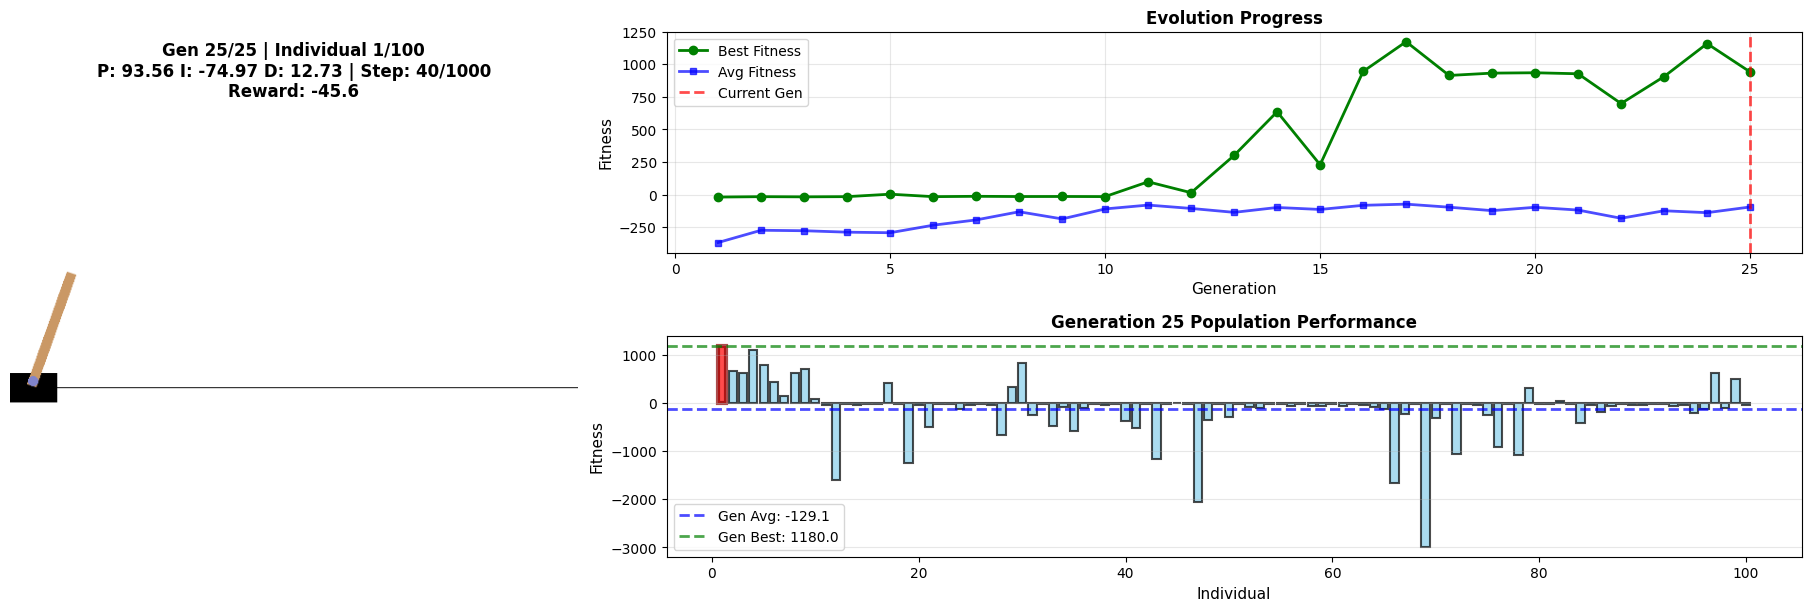


Generation 1/25
Best Fitness: -19.27, Avg Fitness: -368.26
Best PID: Kp=75.735, Ki=82.062, Kd=14.974
------------------------------------------------------------

Generation 2/25
Best Fitness: -16.24, Avg Fitness: -274.13
Best PID: Kp=70.928, Ki=69.638, Kd=12.560
------------------------------------------------------------

Generation 2/25
Best Fitness: -16.24, Avg Fitness: -274.13
Best PID: Kp=70.928, Ki=69.638, Kd=12.560
------------------------------------------------------------

Generation 3/25
Best Fitness: -17.58, Avg Fitness: -277.78
Best PID: Kp=27.582, Ki=13.366, Kd=8.923
------------------------------------------------------------

Generation 3/25
Best Fitness: -17.58, Avg Fitness: -277.78
Best PID: Kp=27.582, Ki=13.366, Kd=8.923
------------------------------------------------------------

Generation 4/25
Best Fitness: -16.00, Avg Fitness: -288.82
Best PID: Kp=27.582, Ki=13.366, Kd=8.923
------------------------------------------------------------

Generation 4/25
Best Fit

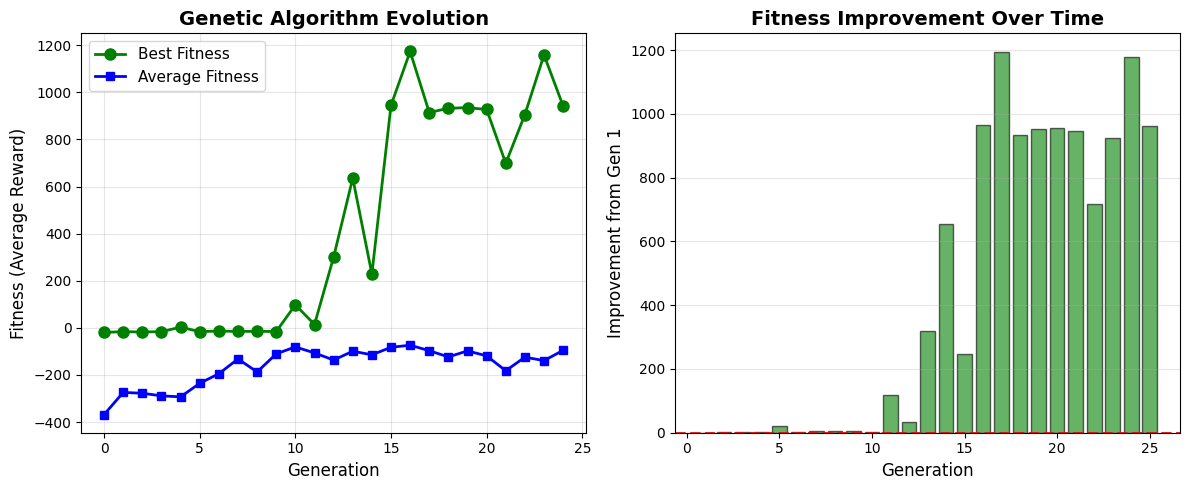

In [10]:
#========================================
# No Changes need to be made in this cell
#========================================
# Time to Run the Genetic Algorithm

# This looks intimidating, but it's just setting up and running the 
# GA with the parameters you've defined above. Most of the code is for plotting
# and displaying results nicely.

print("\n" + "="*70)
print("STARTING GENETIC ALGORITHM")
print("="*70)

# Create GA instance using hyperparameters
ga = GeneticAlgorithm(evaluate_pid=evaluate_pid)

print(f"\nSearch Configuration:")
print(f"  Population: {ga.population_size} individuals")
print(f"  Generations: {ga.generations}")
print(f"  Parameter ranges: Kp{ga.kp_range}, Ki{ga.ki_range}, Kd{ga.kd_range}")
print(f"  Mutation: rate={MUTATION_RATE}, effect={MUTATION_EFFECT}")
print(f"  Crossover rate: {CROSSOVER_RATE}")
print(f"  Elitism: {ELITISM}")
print("="*70 + "\n")

best_pid, best_fitness = ga.evolve()

print("\n" + "=" * 60)
print("FINAL RESULTS")
print("=" * 60)
print(f"Best PID Parameters: Kp={best_pid[0]:.3f}, Ki={best_pid[1]:.3f}, Kd={best_pid[2]:.3f}")
print(f"Best Fitness (Average Reward): {best_fitness:.2f}")

# Plot the evolution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(ga.best_fitness_history, 'g-o', linewidth=2, markersize=8, label='Best Fitness')
plt.plot(ga.avg_fitness_history, 'b-s', linewidth=2, markersize=6, label='Average Fitness')
plt.xlabel('Generation', fontsize=12)
plt.ylabel('Fitness (Average Reward)', fontsize=12)
plt.title('Genetic Algorithm Evolution', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
improvement = np.array(ga.best_fitness_history) - ga.best_fitness_history[0]
plt.bar(range(1, len(improvement)+1), improvement, color='green', alpha=0.6, edgecolor='black')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Generation', fontsize=12)
plt.ylabel('Improvement from Gen 1', fontsize=12)
plt.title('Fitness Improvement Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 3D Fitness Landscape Visualization

This visualization shows the fitness of every individual across all generations. It's a great way to see:
- How the population spreads out initially (exploration)
- How it converges over time (exploitation)
- Which individuals dominated each generation
- Whether the population maintained diversity or got stuck

**What you're looking at:**
- X-axis: Individual number (1 to POPULATION_SIZE)
- Y-axis: Generation number
- Z-axis (height): Fitness score
- Colors: Fitness level (warmer = better)

**Patterns to look for:**
- **Steady climb:** Heights increase over generations = evolution working
- **Plateau:** Flat top = converged (or stuck in local optimum)
- **Wide spread:** Bars vary a lot = high diversity (good early, concerning late)
- **Narrow peaks:** All bars similar = low diversity (good if fitness is high, bad if it's low)
- **Single tall bar with low others:** Elitism keeping the best while exploring

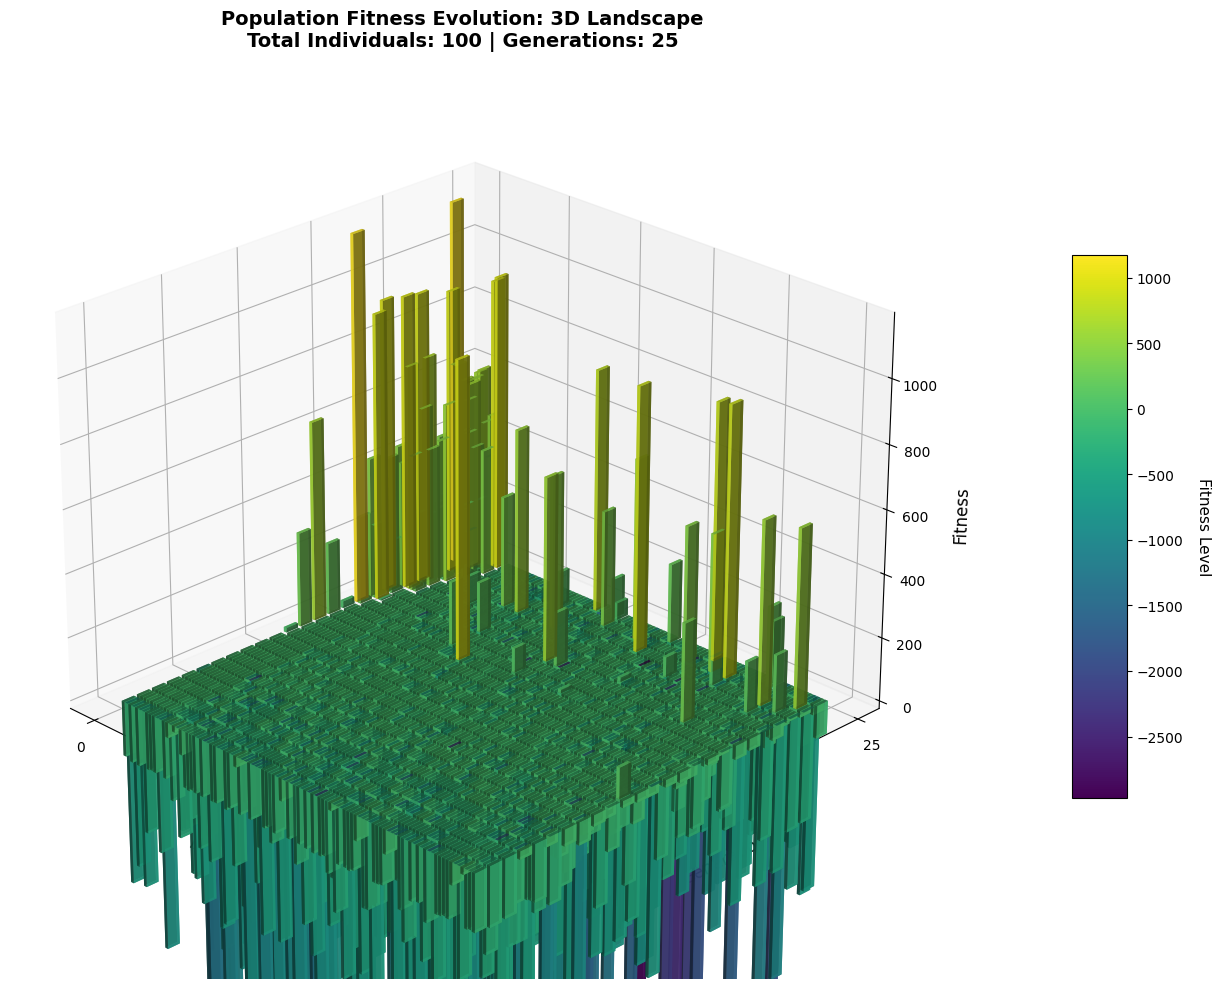

3D FITNESS LANDSCAPE STATISTICS
Total evaluations: 2500
Fitness range: -2968.46 to 1173.66
Overall improvement: 1541.92 (-418.7%)

First generation - Mean: -368.26, Std: 344.18
Last generation  - Mean: -95.47, Std: 435.29

Diversity trend: Maintaining diversity


In [11]:
#========================================
# No Changes need to be made in this cell
#========================================
from mpl_toolkits.mplot3d import Axes3D

# Create 3D fitness landscape
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Prepare data
num_generations = len(ga.individual_fitness_history)
num_individuals = ga.population_size

# Create meshgrid for bar positions
xpos, ypos = np.meshgrid(np.arange(num_individuals), np.arange(num_generations))
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)

# Flatten fitness data for bar heights
fitness_data = np.array(ga.individual_fitness_history)
dz = fitness_data.flatten()

# Bar dimensions
dx = dy = 0.8

# Color mapping based on fitness (normalize to 0-1 range)
colors = plt.cm.viridis((dz - dz.min()) / (dz.max() - dz.min() + 1e-8))

# Create 3D bar chart
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors, shade=True, alpha=0.8)

# Labels and title
ax.set_xlabel('Individual', fontsize=12, labelpad=10)
ax.set_ylabel('Generation', fontsize=12, labelpad=10)
ax.set_zlabel('Fitness', fontsize=12, labelpad=10)
ax.set_title('Population Fitness Evolution: 3D Landscape\n' +
             f'Total Individuals: {num_individuals} | Generations: {num_generations}',
             fontsize=14, fontweight='bold', pad=20)

# Set better viewing angle
ax.view_init(elev=25, azim=-45)

# Add colorbar
mappable = plt.cm.ScalarMappable(cmap='viridis',
                                  norm=plt.Normalize(vmin=dz.min(), vmax=dz.max()))
mappable.set_array(dz)
cbar = plt.colorbar(mappable, ax=ax, shrink=0.6, aspect=10, pad=0.1)
cbar.set_label('Fitness Level', rotation=270, labelpad=20, fontsize=11)

# Grid for better depth perception
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some statistics
print("="*70)
print("3D FITNESS LANDSCAPE STATISTICS")
print("="*70)
print(f"Total evaluations: {num_individuals * num_generations}")
print(f"Fitness range: {dz.min():.2f} to {dz.max():.2f}")
print(f"Overall improvement: {dz.max() - fitness_data[0].mean():.2f} ({((dz.max() - fitness_data[0].mean()) / fitness_data[0].mean() * 100):.1f}%)")
print(f"\nFirst generation - Mean: {fitness_data[0].mean():.2f}, Std: {fitness_data[0].std():.2f}")
print(f"Last generation  - Mean: {fitness_data[-1].mean():.2f}, Std: {fitness_data[-1].std():.2f}")
print(f"\nDiversity trend: {'Converging' if fitness_data[-1].std() < fitness_data[0].std() else 'Maintaining diversity'}")
print("="*70)

Demonstrating the best PID controller...
Using: Kp=93.557, Ki=-74.972, Kd=12.728

Watch the CartPole balance below:


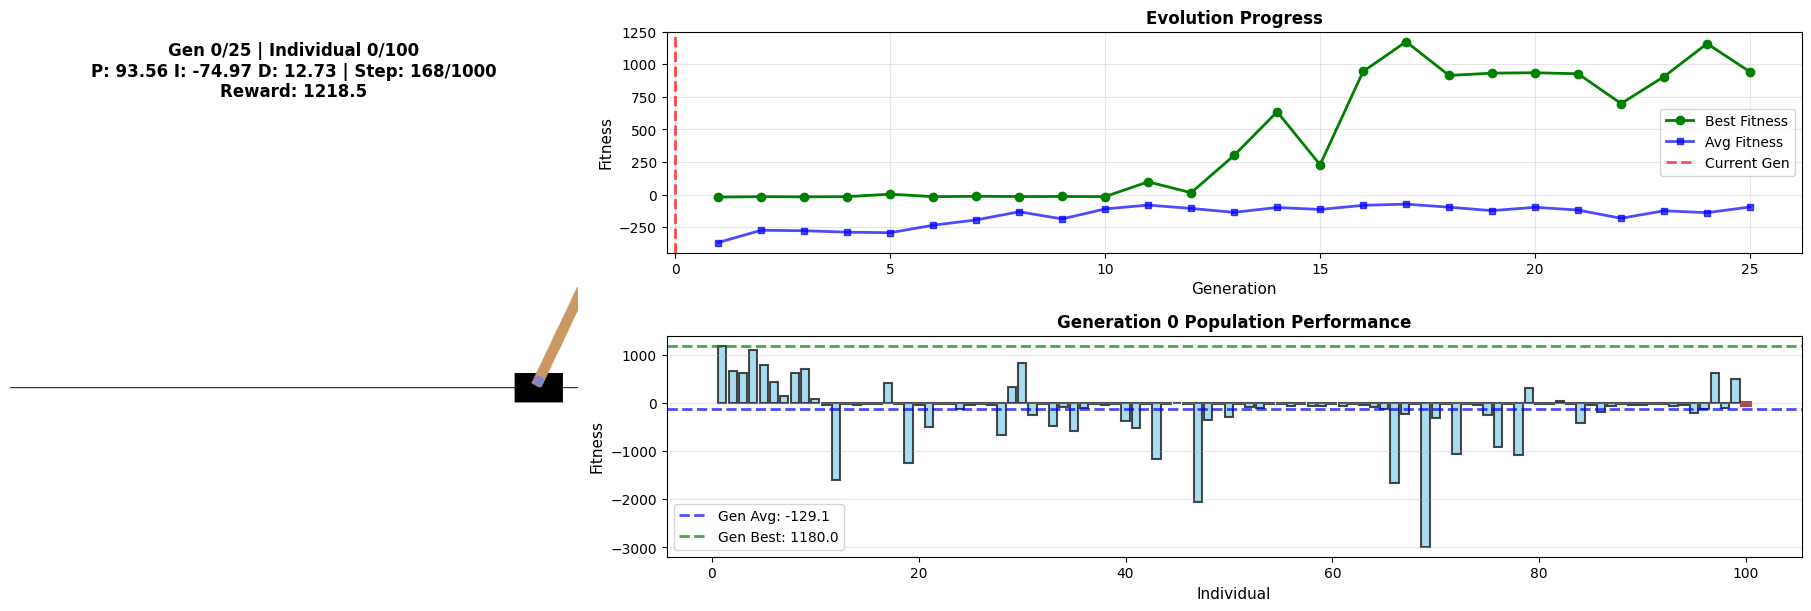


Final score: 1156.74


In [12]:
# Demonstrate the best controller with visualization
print("Demonstrating the best PID controller...")
print(f"Using: Kp={best_pid[0]:.3f}, Ki={best_pid[1]:.3f}, Kd={best_pid[2]:.3f}")
print("\nWatch the CartPole balance below:")
_global_fig = None
_global_axs = None
_global_display_handle = None
_global_img_plot = None

# Run one episode with rendering
final_score = evaluate_pid(best_pid[0], best_pid[1], best_pid[2], render=True,
                             ga_instance=ga, current_gen=0,step_size=7,
                             current_individual=0,episodes=1)
print(f"\nFinal score: {final_score:.2f}")